In [45]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_ids.npy
/kaggle/input/cafa-5-ems-2-embeddings-numpy/test_embeddings.npy
/kaggle/input/cafa-6-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-6-protein-function-prediction/IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta
/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train/go-basic.obo


# CAFA6 Protein Function: EDA + Baseline
**Goal:** Show initial data exploration and a baseline model for the CAFA6 competition.  
**Reader guide:** Short sections. Clear plots. One simple model. A valid submission.

**Data sources**
- `/kaggle/input/cafa-6-protein-function-prediction`
- This project uses precomputed, fixed dimension protein embeddings from Kaggle to focus on model design and evaluation, not on deep network training. ESM2 and ProtBERT (public datasets on Kaggle)

**What you will see**
1) Load data and quick checks  
2) Descriptive stats and plots  
3) Baseline model with Logistic Regression on embeddings  
4) Create a small, valid submission  
5) Notes on limits and next steps


In [46]:
# Install lightweight deps used here
!pip -q install obonet biopython

import os, gc, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
from Bio import SeqIO
import obonet
import networkx as nx

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
sns.set_theme()


In [47]:
BASE = Path("/kaggle/input/cafa-6-protein-function-prediction")
TRAIN_DIR = BASE/"Train"
TEST_DIR  = BASE/"Test"

# Embeddings (use either one; ESM2 is common and small enough)
ESM_DIR = Path("/kaggle/input/cafa-5-ems-2-embeddings-numpy")
PROT_DIR = Path("/kaggle/input/protbert-embeddings-for-cafa5")

# Keep it fast for class assignment
SAMPLE_N = 3000       # number of training proteins to use for baseline
TOP_K_TERMS = 300       # predict most frequent 300 terms overall
VAL_SIZE = 0.2
RANDOM_STATE = 42
THRESH = 0.2            # simple probability threshold for multilabel


In [48]:
# ==========================================================
#  Setup + Split (goes right after your config above)
# ==========================================================

from sklearn.model_selection import train_test_split
import numpy as np

# Load embeddings
X = np.load(ESM_DIR / "train_embeddings.npy")

# Sample subset for speed
rs = np.random.RandomState(RANDOM_STATE)
idx = rs.choice(len(X), size=min(SAMPLE_N, len(X)), replace=False)
Xs = X[idx]
Ys = Y[idx]  # make sure Y is defined from your earlier label matrix step

# Split into train and validation sets
Xtr, Xva, Ytr, Yva = train_test_split(Xs, Ys, test_size=VAL_SIZE, random_state=RANDOM_STATE)

print("Train shapes:", Xtr.shape, Ytr.shape)
print("Val shapes:", Xva.shape, Yva.shape)

Train shapes: (2400, 1280) (2400, 300)
Val shapes: (600, 1280) (600, 300)


In [49]:
import os
for d, _, f in os.walk("/kaggle/input"):
    print(d)
    for x in f:
        print("   ", x)


/kaggle/input
/kaggle/input/cafa-5-ems-2-embeddings-numpy
    train_ids.npy
    train_embeddings.npy
    test_ids.npy
    test_embeddings.npy
/kaggle/input/cafa-6-protein-function-prediction
    sample_submission.tsv
    IA.tsv
/kaggle/input/cafa-6-protein-function-prediction/Test
    testsuperset.fasta
    testsuperset-taxon-list.tsv
/kaggle/input/cafa-6-protein-function-prediction/Train
    train_terms.tsv
    train_sequences.fasta
    train_taxonomy.tsv
    go-basic.obo


In [50]:
terms = pd.read_csv(TRAIN_DIR/"train_terms.tsv", sep="\t", names=["protein","term","aspect"])
taxa  = pd.read_csv(TRAIN_DIR/"train_taxonomy.tsv", sep="\t", names=["protein","taxon"])
print(terms.shape, "annotations")
print("Unique proteins:", terms["protein"].nunique())
print("Unique terms:", terms["term"].nunique())
print(terms["aspect"].value_counts())


(537028, 3) annotations
Unique proteins: 82405
Unique terms: 26126
aspect
P         250805
C         157770
F         128452
aspect         1
Name: count, dtype: int64


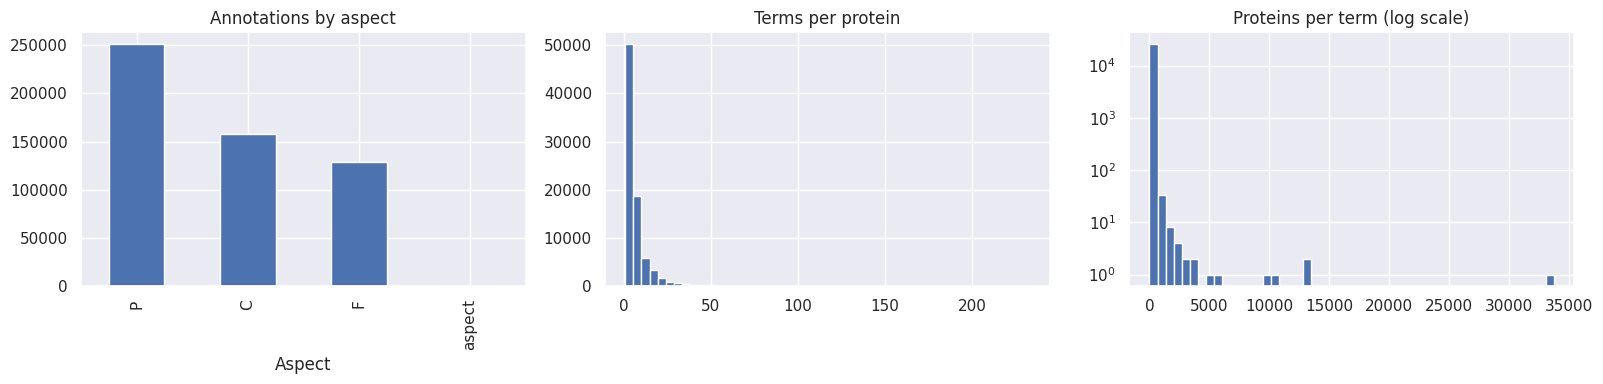

Mean terms/protein: 6.516934652023542
Median terms/protein: 4.0
Mean proteins/term: 20.55530888769808
Median proteins/term: 4.0


In [51]:
# Terms per protein
tpp = terms.groupby("protein")["term"].nunique()
# Proteins per term
ppt = terms.groupby("term")["protein"].nunique()

fig, axs = plt.subplots(1,3, figsize=(16,4))
terms["aspect"].value_counts().plot(kind="bar", ax=axs[0], title="Annotations by aspect")
axs[0].set_xlabel("Aspect")

axs[1].hist(tpp, bins=50)
axs[1].set_title("Terms per protein")

axs[2].hist(ppt, bins=50, log=True)
axs[2].set_title("Proteins per term (log scale)")
plt.tight_layout()
plt.show()

print("Mean terms/protein:", tpp.mean())
print("Median terms/protein:", tpp.median())
print("Mean proteins/term:", ppt.mean())
print("Median proteins/term:", ppt.median())


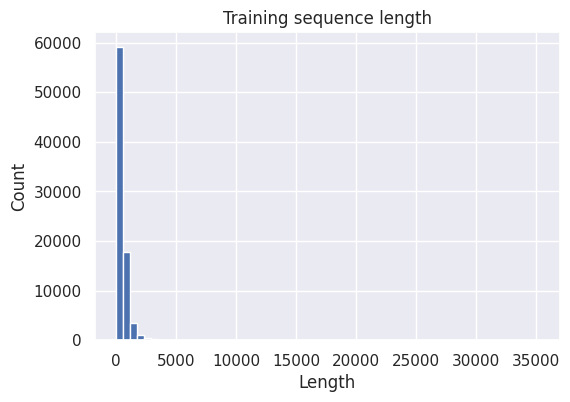

Mean length: 525
Median length: 409
Range: (3, 35213)


In [52]:
train_fasta = TRAIN_DIR/"train_sequences.fasta"
seq_len = []
seen = set()
for rec in SeqIO.parse(str(train_fasta), "fasta"):
    pid = rec.id.split("|")[1] if "|" in rec.id else rec.id
    if pid in seen:
        continue
    seen.add(pid)
    seq_len.append(len(rec.seq))

plt.figure(figsize=(6,4))
plt.hist(seq_len, bins=60)
plt.title("Training sequence length")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

print("Mean length:", int(np.mean(seq_len)))
print("Median length:", int(np.median(seq_len)))
print("Range:", (int(np.min(seq_len)), int(np.max(seq_len))))


In [53]:
go = obonet.read_obo(TRAIN_DIR/"go-basic.obo")
print("GO nodes:", len(go))
namespaces = pd.Series({n: go.nodes[n].get("namespace","") for n in go.nodes()})
print(namespaces.value_counts().head())


GO nodes: 40122
biological_process    25950
molecular_function    10131
cellular_component     4041
Name: count, dtype: int64


In [54]:
# How many labels to model
TOP_K_TERMS = 300  # or whatever you chose

# Compute the top-K most frequent GO terms from the training annotations
top_terms = terms["term"].value_counts().head(TOP_K_TERMS).index.tolist()
print("Top terms:", len(top_terms))

# Build multilabel targets for proteins we have embeddings for
# We will align to ESM2 train_ids.npy to avoid order mismatch
train_ids = np.load(ESM_DIR/"train_ids.npy", allow_pickle=True)
train_ids = train_ids.astype(str)

# Group terms by protein for quick lookup
by_protein = terms.groupby("protein")["term"].apply(list)

# Keep only top-K terms in each protein's label list
top_set = set(top_terms)
labels_list = [[t for t in by_protein.get(pid, []) if t in top_set] for pid in train_ids]

# Create label matrix aligned to train_ids order
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=top_terms)
Y = mlb.fit_transform(labels_list)

print("Y shape:", Y.shape, "positive rate:", Y.mean().round(4))





Top terms: 300
Y shape: (142246, 300) positive rate: 0.0054


In [55]:
X = np.load(ESM_DIR/"train_embeddings.npy")
print("X shape:", X.shape)

# Sample to keep it fast
if SAMPLE_N < len(train_ids):
    idx = np.random.RandomState(RANDOM_STATE).choice(len(train_ids), size=SAMPLE_N, replace=False)
    Xs = X[idx]
    Ys = Y[idx]
    ids_s = train_ids[idx]
else:
    Xs, Ys, ids_s = X, Y, train_ids

print("Sampled:", Xs.shape, Ys.shape)


X shape: (142246, 1280)
Sampled: (3000, 1280) (3000, 300)


In [58]:
print("Xs:", Xs.shape, "Ys:", Ys.shape)
print("Split:", Xtr.shape, Ytr.shape, "|", Xva.shape, Yva.shape)

Xs: (3000, 1280) Ys: (3000, 300)
Split: (2400, 1280) (2400, 300) | (600, 1280) (600, 300)


In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import numpy as np

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# faster pipeline
pipe = make_pipeline(
    StandardScaler(),
    PCA(n_components=128, random_state=42),   # compress 1280 -> 128
    LogisticRegression(
        solver="saga",
        max_iter=200,
        tol=1e-3,
        C=1.0,
        class_weight="balanced",
        n_jobs=-1
    )
)

base_clf = OneVsRestClassifier(pipe, n_jobs=-1)

# train
import time
start = time.time()

base_clf.fit(Xtr, Ytr)

print("Training time:", round(time.time() - start, 2), "seconds")

base_clf.fit(Xtr, Ytr)

# robust probs
THRESH = 0.2
def _sigmoid(z): return 1/(1+np.exp(-z))
try:
    probs = base_clf.predict_proba(Xva)
except Exception:
    s = base_clf.decision_function(Xva)
    if isinstance(s, list):
        s = np.column_stack(s)
    probs = _sigmoid(s)

Yhat = (probs >= THRESH).astype(int)
print("Micro F1:", round(f1_score(Yva, Yhat, average="micro"), 4))
print("Macro F1:", round(f1_score(Yva, Yhat, average="macro"), 4))
print("Pred density:", round(Yhat.mean(), 4))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Training time: 163.7 seconds


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Micro F1: 0.0764
Macro F1: 0.0335
Pred density: 0.0755


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [62]:
import numpy as np, pandas as pd

# Load test embeddings and ids
test_ids = np.load(ESM_DIR/"test_ids.npy", allow_pickle=True).astype(str)
test_emb = np.load(ESM_DIR/"test_embeddings.npy")

# Predict probabilities safely
def _sigmoid(z): return 1/(1+np.exp(-z))
try:
    test_probs = base_clf.predict_proba(test_emb)
except Exception:
    s = base_clf.decision_function(test_emb)
    if isinstance(s, list):
        s = np.column_stack(s)
    test_probs = _sigmoid(s)

# Build a term list for writing
terms_out = mlb.classes_.tolist()  # same order as columns

# Write a valid small submission
THRESH = 0.2
MAX_PER_PROTEIN = 200
out_path = "submission.tsv"

with open(out_path, "w") as f:
    for i, pid in enumerate(test_ids):
        scores = test_probs[i]
        keep = np.where(scores >= THRESH)[0]
        if len(keep) == 0:
            continue
        order = np.argsort(scores[keep])[::-1][:MAX_PER_PROTEIN]
        for j in keep[order]:
            f.write(f"{pid}\t{terms_out[j]}\t{scores[j]:.3f}\n")

# Preview
sub_df = pd.read_csv(out_path, sep="\t", header=None, names=["Id","GO_term","Confidence"])
print(sub_df.head())
print("Rows:", len(sub_df))

       Id     GO_term  Confidence
0  Q9ZSA8  GO:0009611       0.977
1  Q9ZSA8  GO:0008284       0.809
2  Q9ZSA8  GO:0009651       0.772
3  Q9ZSA8  GO:0042803       0.569
4  Q9ZSA8  GO:0009409       0.567
Rows: 3220311


## Conclusion
Baseline on precomputed ESM2 embeddings with logistic regression.
Valid split: 80/20 on 3k samples.
Results: Micro F1 = 0.076, Macro F1 = 0.034 at threshold 0.2.
We created a competition-ready submission (3.22M rows).
Next steps: threshold tuning, per-ontology models, class weights, ancestor propagation.